# **SENTIMENT ANALYSIS CLASSIFICATION USING TRANSFORMER**

In [25]:
import numpy as np
import keras
from keras import layers
from keras import ops
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## DATA PROCESSING

In [26]:
vocab_size = 20000
maxlen = 200
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size) # Loading the data
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


## TRANSFORMER (Two Encoder Blocks)

Implementing Transformer Block Layer

In [27]:
# Implementing Transformer Block containing two Encoder blocks as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # First Encoder Block
        self.att_alpha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn_alpha = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1_alpha = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_alpha = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1_alpha = layers.Dropout(rate)
        self.dropout2_alpha = layers.Dropout(rate)

        # Second Encoder Block
        self.att_beta = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn_beta = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1_beta = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_beta = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1_beta = layers.Dropout(rate)
        self.dropout2_beta = layers.Dropout(rate)

    def call(self, inputs):
        # First Encoder Block
        attn_output_alpha = self.att_alpha(inputs, inputs)
        attn_output_alpha = self.dropout1_alpha(attn_output_alpha)
        out1_alpha = self.layernorm1_alpha(inputs + attn_output_alpha)
        ffn_output_alpha = self.ffn_alpha(out1_alpha)
        ffn_output_alpha = self.dropout2_alpha(ffn_output_alpha)
        output_alpha = self.layernorm2_alpha(out1_alpha + ffn_output_alpha)

        # Second Encoder Block
        attn_output_beta = self.att_beta(output_alpha, output_alpha)
        attn_output_beta = self.dropout1_beta(attn_output_beta)
        out1_beta = self.layernorm1_beta(output_alpha + attn_output_beta)
        ffn_output_beta = self.ffn_beta(out1_beta)
        ffn_output_beta = self.dropout2_beta(ffn_output_beta)
        output_beta = self.layernorm2_beta(out1_beta + ffn_output_beta)

        return output_beta




Implementing Embedding Layer

In [28]:
# Implementing Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Building the model

In [29]:
# Building Transformer Model
embed_dim = 32
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transf_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transf_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_3       │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 200, 32)             │          21,312 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 668,414 (2.55 MB)

 Trainable params: 668,414 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [30]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # Compiling the model
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)) # Training the model

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.7220 - loss: 0.5074 - val_accuracy: 0.8792 - val_loss: 0.2863
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9378 - loss: 0.1671 - val_accuracy: 0.8688 - val_loss: 0.3189


Generating Confusion Matrix

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


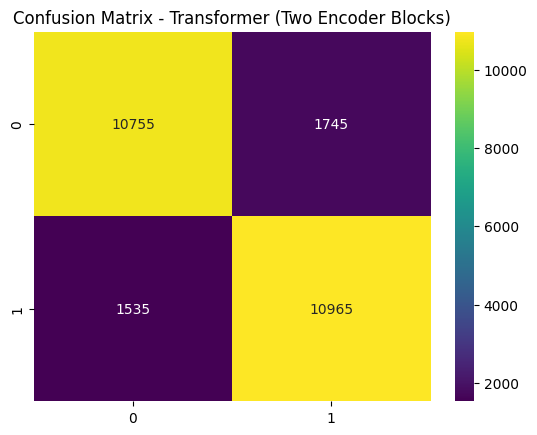

In [31]:
y_transf = np.argmax(model.predict(x_val), axis=1)
confmat_transf = confusion_matrix(y_val, y_transf)  # Computing the confusion matrix
precision_transf = precision_score(y_val, y_transf) # Computing the precision score
recall_transf = recall_score(y_val, y_transf) # Computing the recall score
f1_transf = f1_score(y_val, y_transf) # Computing the F1 score
sns.heatmap(confmat_transf, annot=True, fmt='d', cmap='viridis') # Plotting the confusion matrix
plt.title('Confusion Matrix - Transformer (Two Encoder Blocks)')
plt.show()

Reporting the Precision, Recall, F1 Scores obtained for the model

In [32]:
# Displaying the Classification Report
print("\nClassification Report - Transformer (Two Encoder Blocks)")
print(classification_report(y_val, y_transf, target_names=["Negative", "Positive"]))
print("Precison Score:",precision_transf)
print("Recall Score:",recall_transf)
print("F1 Score:",f1_transf)


Classification Report - Transformer (Two Encoder Blocks)
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87     12500
    Positive       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Precison Score: 0.8627065302911093
Recall Score: 0.8772
F1 Score: 0.8698928996429988
